hidden neurons None
n_estimators 100
max samples 512

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.98      0.70      2498
       Relay       0.72      0.05      0.09      2166

    accuracy                           0.55      4664
   macro avg       0.63      0.52      0.39      4664
weighted avg       0.63      0.55      0.42      4664



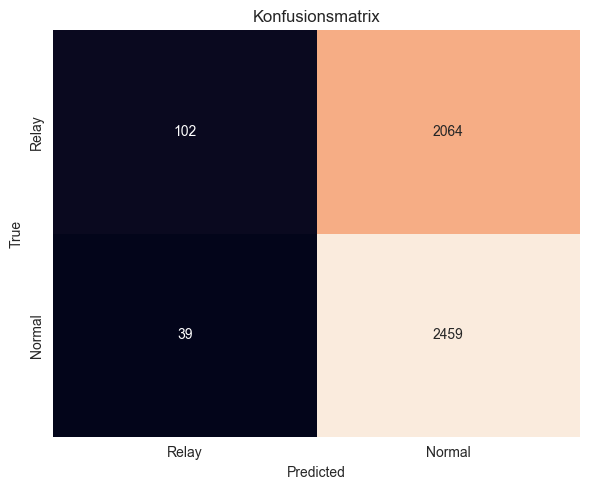

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from pyod.models.dif import DIF

# daten laden
normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File("datasets/transients_cleaned_padded.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49998, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49998):
        dataset_normal[i] = normal_group[str(i)][:]
    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

# daten definieren und skalieren
scaler = MinMaxScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]      # 2498 Normal
X_test_relay          = dataset_relay[47500:]        # 2166 Relay

scaler.fit(X_train)
X_train_scaled        = scaler.transform(X_train)
X_test_norm_scaled    = scaler.transform(X_test_normal)
X_test_relay_scaled   = scaler.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled = np.vstack((X_test_norm_scaled, X_test_relay_scaled))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for e in {100}:
    for m in {512}:
        clf = DIF(contamination=0.01, hidden_neurons=(1024, 512, 256), max_samples=m, n_estimators=e, random_state=42)
        clf.fit(X_train_scaled)

        # pyod.predict: 0 = inlier, 1 = outlier
        y_pred = clf.predict(X_test_combined_scaled)

        # cm und report
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        print(f"hidden neurons {n}")
        print(f"n_estimators {e}")
        print(f"max samples {m}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

        # plot
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["Relay","Normal"],
                    yticklabels=["Relay","Normal"],
                    cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfusionsmatrix")
        plt.tight_layout()
        plt.show()